In [90]:
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from pydantic import Field , BaseModel
from langchain_groq import ChatGroq
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from dotenv import load_dotenv
import pymysql
import os

load_dotenv()

True

In [91]:
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_NAME = os.getenv('DB_NAME')
genai_api_key = os.getenv("GOOGLE_GEMINI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
encoded_password = quote_plus(DB_PASSWORD)

In [92]:
engine = create_engine(f'mysql+pymysql://{DB_USER}:{encoded_password}@{DB_HOST}/{DB_NAME}')
db = SQLDatabase(engine=engine)
llm = ChatGroq(model="llama3-8b-8192")

In [93]:
print(db.get_usable_table_names())

['accounts', 'customers', 'transactions']


In [94]:
from typing_extensions import TypedDict , Literal , Annotated

from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import QuerySQLCheckerTool
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_core.messages import SystemMessage , HumanMessage
from langgraph.graph import StateGraph,END,START
from IPython.display import Image, display



In [95]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str
    correct_or_not : str

In [111]:
system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.
Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.
Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.
Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.
Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [131]:
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]
    
def Generate(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    print("Generated")
    return {"query": result["query"]}

In [132]:
def Execute(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    print("Executed")
    return {"result": execute_query_tool.invoke(state["query"])}

In [133]:
class Routes(BaseModel):
    route : Literal["Generate","Execute"] = Field(description="Decide weather to rewrite query by generating again or Execute")

router = llm.with_structured_output(Routes)

In [ ]:
def Check(state: State):
    """Check SQL query for common mistakes."""
    checker_tool = QuerySQLCheckerTool(db=db, llm=llm)
    checked_result = checker_tool.invoke({"query": state["query"]})
    routing = router.invoke([SystemMessage(content="Decide weather to Generate or Execute"),
                             HumanMessage(content=checked_result)])
    return{"correct_or_not":routing.route}
    


In [ ]:
def next_route(state:State):
    routing = router.invoke([SystemMessage(content="Decide weather to Generate or Execute"),
                             HumanMessage(content=state['answer'])])
    return{"correct_or_not":routing.route}

In [126]:
def Answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    print(response)
    return {"answer": response.content}

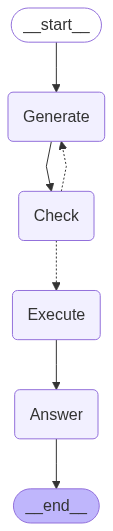

In [127]:
graph = StateGraph(State)
graph.add_node("Generate",Generate)
graph.add_node("Execute",Execute)
graph.add_node("Answer",Answer)
graph.add_node("Check",Check)

graph.add_edge(START,"Generate")
graph.add_edge("Generate","Check")
graph.add_conditional_edges("Check",next_route,{"Generate":"Generate","Execute": "Execute"})
graph.add_edge("Execute","Answer")
graph.add_edge("Answer",END)
graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [130]:
input_state = {"question": "How many accounts are there?"}
graph_builder.invoke(input_state)

TypeError: unhashable type: 'dict'